# Capstone Project - Predicting Commercial Fishing Habits

## Overview of Process - CRISP-DM
1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment

# 1. Business Understanding
According to NOAA, illegal, unreported, and unregulated fishing activities (`IUU`) violate both national and international fishing regulations. IUU is a global problem that threatens ocean ecosystems and sustainable fisheries.  It also threatens economic secuity and the natural resources that are critical to global food security. IUU also puts law-abiding fishing operations at a disadvantage. 

Illegal fishing refers to fishing activities conducted in contravention of applicable laws and regulations, including those laws and rules adopted at the regional and international level. 

Unreported fishing refers to fishing activities that are not reported or are misreported to relevant authorities in contravention of national laws and regulations or reporting procedures of a relevant regional fisheries management organization.

Unregulated fishing occurs in areas or for fish stocks for which there are no applicable conservation or management measures and where such fishing activities are conducted in a manner inconsistent with State responsibilities for the conservation of living marine resources under international law. Fishing activities are also unregulated when occurring in an RFMO-managed area and conducted by vessels without nationality, or by those flying a flag of a State or fishing entity that is not party to the RFMO in a manner that is inconsistent with the conservation measures of that RFMO. https://www.fisheries.noaa.gov/insight/understanding-illegal-unreported-and-unregulated-fishing

AIS stands for Automatic Identification System, and is used for tracking marine vessel traffic data. AIS data is collected by the US Coast Guard through an onboard safety navigation device that transmits and monitors the location and characteristics of large vessels in the US and international waters in real time. In the United States, the Coast Guard and commercial vendors collect AIS data, which can also be used for a variety of coastal planning initiatives. https://marinecadastre.gov/ais/

AIS is a maritime navigation safety communications system standardized by the international telecommunications union and adopted by the International Maritime Organization (IMO) that provides vessel information, including the vessel's identity, type, position, course, speed, navigational status and other safety-related information automatically to appropriately equipped shore stations, other ships, and aircraft; receives automatically such information from similarly fitted ships; monitors and tracks ships; and exchanges data with shore-based facilities. More information can be found here https://www.navcen.uscg.gov/?pageName=AISFAQ#1

# 2. Data Understanding

1. What data is available to us? Where does it come from?
2. Who controls the data and what steps are needed to access the data?
3. What is our target?
4. What predictors are available to us?
5. What data types are the predictors?
6. What is the distribution of our data?
7. How big is our data?
8. Do we have enough data to build a model? Will we need to use resampling?
9. How do we know the data is correct?  Is there a chance the data is wrong?

Two primary datasets will be used for this process:
1. Vessel AIS data sourced from Global Fishing Watch
2. Various ocean measurements and Ocean Station Data sourced from NOAA and the World Ocean Database

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime

# set visualization style
plt.style.use('ggplot')

## AIS Data (Global Fishing Watch)
Global fishing watch dataset was sourced from `https://globalfishingwatch.org/data-download/`. 7 separate files were downloaded, each corresponding to a type of fishing vessel:
1. `drifting_longlines.csv`
2. `fixed_gear.csv`
3. `pole_and_line.csv`
4. `purse_seines.csv`
5. `trawlers.csv`
6. `trollers.csv`
7. `unknown.csv`

In [2]:
# load datasets
drifting_longlines = pd.read_csv('datasets/drifting_longlines.csv')
fixed_gear = pd.read_csv('datasets/fixed_gear.csv')
pole_and_line = pd.read_csv('datasets/pole_and_line.csv')
purse_seines = pd.read_csv('datasets/purse_seines.csv')
trawlers = pd.read_csv('datasets/trawlers.csv')
trollers = pd.read_csv('datasets/trollers.csv')
unknown = pd.read_csv('datasets/unknown.csv')

Per Global Fishing Watch each dataset contains the following columns:
* `mmsi` - anonymized vessel identifier
* `timestamp` - unix timestamp
* `distance_from_shore` - distance from shore in meters
* `distance_from_port` - distance from port in meters
* `speed` - vessel speed in knots
* `course` - vessel course
* `lat` - latitude in decimal degrees
* `long` - longitude in decimal degrees
* `source` - The training data batch. Data was prepared by GFW, Dalhousie, and a crowd sourcing campaign. False positives are marked as false_positives
* `vessel_type` - type of vessel
* `is_fishing` - label indicating fishing activity
    * `0` = not fishing
    * `>0` = fishing. Data values between 0 and 1 indicate the average score for the position if scored by multiple people
    * `-1` = no data. 
    
`is_fishing` will be our primary target variable, with other columns available to us used as features. 

### AIS - Drifting Longlines

In [3]:
# display top 5 rows
drifting_longlines.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
0,1.263956e+13,1.327137e+09,232994.281250,311748.65625,8.2,230.500000,14.865583,-26.853662,-1.0,dalhousie_longliner
1,1.263956e+13,1.327137e+09,233994.265625,312410.34375,7.3,238.399994,14.863870,-26.856800,-1.0,dalhousie_longliner
2,1.263956e+13,1.327137e+09,233994.265625,312410.34375,6.8,238.899994,14.861551,-26.860649,-1.0,dalhousie_longliner
3,1.263956e+13,1.327143e+09,233994.265625,315417.37500,6.9,251.800003,14.822686,-26.865898,-1.0,dalhousie_longliner
4,1.263956e+13,1.327143e+09,233996.390625,316172.56250,6.1,231.100006,14.821825,-26.867579,-1.0,dalhousie_longliner


In [4]:
# display info
drifting_longlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13968727 entries, 0 to 13968726
Data columns (total 10 columns):
 #   Column               Dtype  
---  ------               -----  
 0   mmsi                 float64
 1   timestamp            float64
 2   distance_from_shore  float64
 3   distance_from_port   float64
 4   speed                float64
 5   course               float64
 6   lat                  float64
 7   lon                  float64
 8   is_fishing           float64
 9   source               object 
dtypes: float64(9), object(1)
memory usage: 1.0+ GB


In [5]:
# display summary statistics for continuous columns
drifting_longlines.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,1.396873e+07,1.396873e+07,1.396873e+07,1.396873e+07,1.396863e+07,1.396863e+07,1.396873e+07,1.396873e+07,1.396873e+07
mean,1.293850e+14,1.434290e+09,5.845311e+05,7.897505e+05,5.464779e+00,1.814876e+02,-8.997629e+00,3.758693e+00,-9.743015e-01
std,7.887357e+13,3.984275e+07,5.420068e+05,6.915438e+05,4.043567e+00,1.050503e+02,2.439311e+01,1.095971e+02,2.119947e-01
min,5.601266e+12,1.325376e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.519017e+01,-1.800000e+02,-1.000000e+00
25%,6.260384e+13,1.410706e+09,1.019092e+05,2.130206e+05,2.100000e+00,9.070000e+01,-2.601550e+01,-8.808668e+01,-1.000000e+00
50%,1.184859e+14,1.447302e+09,4.576393e+05,6.375249e+05,5.500000e+00,1.811000e+02,-1.497954e+01,-1.716495e+00,-1.000000e+00
75%,1.980758e+14,1.466506e+09,9.603664e+05,1.210432e+06,8.500000e+00,2.711000e+02,4.485790e+00,1.009811e+02,-1.000000e+00
max,2.812058e+14,1.480032e+09,4.430996e+06,7.181037e+06,1.023000e+02,5.110000e+02,8.333266e+01,1.799938e+02,1.000000e+00


In [6]:
# display number of unique vessels
drifting_longline_ids = drifting_longlines['mmsi'].unique()
print(f'There are {len(drifting_longline_ids)} unique anonymized vessel IDs')

There are 110 unique anonymized vessel IDs


### AIS - Fixed Gear

In [7]:
# display top 5 rows
fixed_gear.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
0,7.572519e+12,1.347664e+09,0.0,36054.625000,0.0,0.000000,42.798748,-8.944992,-1.0,gfw
1,7.572519e+12,1.348056e+09,0.0,36054.625000,0.0,0.000000,42.798717,-8.945075,-1.0,gfw
2,7.572519e+12,1.350409e+09,0.0,90970.296875,0.0,198.199997,43.106419,-9.215466,-1.0,gfw
3,7.572519e+12,1.350410e+09,0.0,90970.296875,0.0,186.899994,43.106434,-9.215431,-1.0,gfw
4,7.572519e+12,1.350411e+09,0.0,90970.296875,0.0,190.500000,43.106430,-9.215442,-1.0,gfw


In [8]:
# display info
fixed_gear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1559137 entries, 0 to 1559136
Data columns (total 10 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   mmsi                 1559137 non-null  float64
 1   timestamp            1559137 non-null  float64
 2   distance_from_shore  1559137 non-null  float64
 3   distance_from_port   1559137 non-null  float64
 4   speed                1559137 non-null  float64
 5   course               1559137 non-null  float64
 6   lat                  1559137 non-null  float64
 7   lon                  1559137 non-null  float64
 8   is_fishing           1559137 non-null  float64
 9   source               1559137 non-null  object 
dtypes: float64(9), object(1)
memory usage: 119.0+ MB


In [9]:
# display summary stats for cont. columns
fixed_gear.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,1.559137e+06,1.559137e+06,1.559137e+06,1.559137e+06,1.559137e+06,1.559137e+06,1.559137e+06,1.559137e+06,1.559137e+06
mean,1.530752e+14,1.421486e+09,3.761878e+04,5.989848e+04,2.227195e+00,1.877938e+02,5.095086e+01,1.274018e+00,-9.659100e-01
std,8.976383e+13,3.782830e+07,1.090188e+05,1.269729e+05,3.412790e+00,1.177506e+02,5.894565e+00,8.512244e+00,2.173124e-01
min,7.572519e+12,1.325625e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.326460e+01,-1.792441e+02,-1.000000e+00
25%,8.878018e+13,1.387594e+09,0.000000e+00,5.656715e+03,0.000000e+00,7.740000e+01,4.745566e+01,-3.909275e+00,-1.000000e+00
50%,1.305289e+14,1.427254e+09,0.000000e+00,2.690659e+04,1.000000e-01,2.055000e+02,5.050242e+01,-2.333808e+00,-1.000000e+00
75%,2.616830e+14,1.455255e+09,3.413126e+04,5.514391e+04,3.800000e+00,2.870000e+02,5.602126e+01,8.220293e+00,-1.000000e+00
max,2.802913e+14,1.480032e+09,3.099833e+06,1.181676e+07,1.023000e+02,5.110000e+02,8.479108e+01,1.709277e+02,1.000000e+00


In [10]:
# display number of unique vessels
fixed_gear_ids = fixed_gear['mmsi'].unique()
print(f'There are {len(fixed_gear_ids)} unique anonymized vessel IDs')

There are 36 unique anonymized vessel IDs


### AIS - Pole and Line

In [11]:
# display top 5 rows
pole_and_line.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
0,1.848346e+13,1.340882e+09,0.000000,2236.013184,0.0,0.000000,28.967354,-13.537797,-1.0,gfw
1,1.848346e+13,1.340884e+09,0.000000,2236.013184,0.0,125.199997,28.967373,-13.537838,-1.0,gfw
2,1.848346e+13,1.340885e+09,0.000000,2236.013184,0.0,0.000000,28.967354,-13.537838,-1.0,gfw
3,1.848346e+13,1.340888e+09,0.000000,2236.013184,0.0,0.000000,28.967354,-13.537838,-1.0,gfw
4,1.848346e+13,1.340925e+09,1999.950928,2828.357666,8.7,203.100006,28.929653,-13.543955,-1.0,gfw


In [12]:
# display info
pole_and_line.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161315 entries, 0 to 161314
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   mmsi                 161315 non-null  float64
 1   timestamp            161315 non-null  float64
 2   distance_from_shore  161315 non-null  float64
 3   distance_from_port   161315 non-null  float64
 4   speed                161315 non-null  float64
 5   course               161315 non-null  float64
 6   lat                  161315 non-null  float64
 7   lon                  161315 non-null  float64
 8   is_fishing           161315 non-null  float64
 9   source               161315 non-null  object 
dtypes: float64(9), object(1)
memory usage: 12.3+ MB


In [13]:
# display summary stats for cont columns
pole_and_line.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,1.613150e+05,1.613150e+05,1.613150e+05,1.613150e+05,161315.000000,161315.000000,161315.000000,161315.000000,161315.000000
mean,7.659841e+13,1.414174e+09,4.894434e+04,7.383040e+04,2.111584,132.245911,33.456753,-4.570087,-0.967918
std,5.740577e+13,4.300647e+07,2.036499e+05,2.333604e+05,3.696588,117.424918,5.665633,53.524248,0.205442
min,1.848346e+13,1.327882e+09,0.000000e+00,0.000000e+00,0.000000,0.000000,-41.853848,-70.921013,-1.000000
25%,1.848346e+13,1.368384e+09,0.000000e+00,2.236013e+03,0.000000,3.300000,28.965940,-28.527719,-1.000000
50%,8.703142e+13,1.423536e+09,0.000000e+00,1.442185e+04,0.000000,115.199997,33.029419,-16.734444,-1.000000
75%,8.703142e+13,1.456109e+09,2.280295e+04,5.324341e+04,1.800000,228.699997,38.531128,-13.539565,-1.000000
max,2.145727e+14,1.480031e+09,2.110362e+06,3.005100e+06,102.300003,360.000000,77.078987,177.632980,1.000000


In [14]:
# number of unique vessels
pole_and_line_ids = pole_and_line['mmsi'].unique()
print(f'There are {len(pole_and_line_ids)} unique anonymized vessel IDs')

There are 6 unique anonymized vessel IDs


### AIS - Purse Seines

In [15]:
# display top 5 rows
purse_seines.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
0,9.924005e+12,1.379601e+09,0.0,1414.178833,0.0,298.500000,8.861500,-79.668427,-1.0,false_positives
1,9.924005e+12,1.379602e+09,0.0,1414.178833,0.0,298.500000,8.861506,-79.668442,-1.0,false_positives
2,9.924005e+12,1.379604e+09,0.0,1414.178833,0.1,128.399994,8.861511,-79.668488,-1.0,false_positives
3,9.924005e+12,1.379605e+09,0.0,1414.178833,0.1,111.199997,8.861511,-79.668480,-1.0,false_positives
4,9.924005e+12,1.379608e+09,0.0,1414.178833,0.0,41.700001,8.861502,-79.668503,-1.0,false_positives


In [16]:
# display info
purse_seines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1545323 entries, 0 to 1545322
Data columns (total 10 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   mmsi                 1545323 non-null  float64
 1   timestamp            1545323 non-null  float64
 2   distance_from_shore  1545323 non-null  float64
 3   distance_from_port   1545323 non-null  float64
 4   speed                1545316 non-null  float64
 5   course               1545316 non-null  float64
 6   lat                  1545323 non-null  float64
 7   lon                  1545323 non-null  float64
 8   is_fishing           1545323 non-null  float64
 9   source               1545323 non-null  object 
dtypes: float64(9), object(1)
memory usage: 117.9+ MB


In [17]:
# summary stats for cont. columns
purse_seines.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,1.545323e+06,1.545323e+06,1.545323e+06,1.545323e+06,1.545316e+06,1.545316e+06,1.545323e+06,1.545323e+06,1.545323e+06
mean,8.788081e+13,1.431543e+09,2.301199e+05,3.420745e+05,5.119294e+00,1.905941e+02,1.390564e+01,1.472753e+01,-9.833250e-01
std,6.522389e+13,3.645865e+07,3.841463e+05,5.070968e+05,5.593512e+00,1.042562e+02,1.891573e+01,1.116258e+02,1.418592e-01
min,9.924005e+12,1.325378e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.922275e+01,-1.800000e+02,-1.000000e+00
25%,3.832297e+13,1.409017e+09,0.000000e+00,8.062060e+03,1.000000e-01,9.820000e+01,-4.091158e-01,-7.966909e+01,-1.000000e+00
50%,5.966517e+13,1.438458e+09,4.049592e+04,9.693059e+04,1.300000e+00,2.034000e+02,5.338995e+00,-1.897600e+00,-1.000000e+00
75%,1.583170e+14,1.462147e+09,2.866600e+05,4.934421e+05,1.120000e+01,2.791000e+02,3.510037e+01,1.410436e+02,-1.000000e+00
max,2.679667e+14,1.480032e+09,2.315626e+06,6.728604e+06,1.023000e+02,5.110000e+02,7.833025e+01,1.799934e+02,1.000000e+00


### AIS - Trawlers

In [18]:
# display top 5 rows
trawlers.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
0,1.252340e+12,1.325376e+09,0.0,0.0,0.0,153.0,52.458649,4.581200,-1.0,gfw
1,1.252340e+12,1.325378e+09,0.0,0.0,0.0,153.0,52.458668,4.581167,-1.0,gfw
2,1.252340e+12,1.325379e+09,0.0,0.0,0.0,153.0,52.458633,4.581183,-1.0,gfw
3,1.252340e+12,1.325380e+09,0.0,0.0,0.0,153.0,52.458649,4.581234,-1.0,gfw
4,1.252340e+12,1.325381e+09,0.0,0.0,0.0,153.0,52.458649,4.581183,-1.0,gfw


In [19]:
# display info
trawlers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4369101 entries, 0 to 4369100
Data columns (total 10 columns):
 #   Column               Dtype  
---  ------               -----  
 0   mmsi                 float64
 1   timestamp            float64
 2   distance_from_shore  float64
 3   distance_from_port   float64
 4   speed                float64
 5   course               float64
 6   lat                  float64
 7   lon                  float64
 8   is_fishing           float64
 9   source               object 
dtypes: float64(9), object(1)
memory usage: 333.3+ MB


In [20]:
# summary stats for cont. columns
trawlers.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,4.369101e+06,4.369101e+06,4.369101e+06,4.369101e+06,4.369023e+06,4.369023e+06,4.369101e+06,4.369101e+06,4.369101e+06
mean,1.578952e+14,1.426220e+09,7.819802e+04,1.496648e+05,2.972401e+00,1.744043e+02,3.266757e+01,4.927771e+00,-9.449078e-01
std,9.494779e+13,3.876472e+07,2.040747e+05,3.279532e+05,4.105081e+00,1.154701e+02,3.837240e+01,8.127552e+01,2.844518e-01
min,1.252340e+12,1.325376e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.498024e+01,-1.799996e+02,-1.000000e+00
25%,7.726193e+13,1.397205e+09,0.000000e+00,2.236013e+03,0.000000e+00,6.480000e+01,3.623107e+01,-8.288531e+00,-1.000000e+00
50%,1.753874e+14,1.434811e+09,4.242537e+03,3.605462e+04,1.500000e+00,1.870000e+02,5.209994e+01,4.584417e+00,-1.000000e+00
75%,2.402260e+14,1.458922e+09,5.578393e+04,9.608094e+04,4.500000e+00,2.760000e+02,5.463578e+01,1.432063e+01,-1.000000e+00
max,2.775153e+14,1.480032e+09,3.257453e+06,1.245220e+07,1.023000e+02,5.110000e+02,8.461642e+01,1.799934e+02,1.000000e+00


In [21]:
# number of unique vessels
trawlers_ids = trawlers['mmsi'].unique()
print(f'There are {len(trawlers_ids)} unique anonymized vessel IDs')

There are 49 unique anonymized vessel IDs


### AIS - Trollers

In [22]:
# display top 5 rows
trollers.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
0,7.652701e+13,1.337836e+09,0.0,3162.200195,0.0,0.000000,51.887592,4.356583,-1.0,gfw
1,7.652701e+13,1.338199e+09,0.0,4999.877441,0.0,0.000000,51.242130,4.403008,-1.0,gfw
2,7.652701e+13,1.343752e+09,0.0,66308.250000,8.6,292.200012,51.960873,5.196125,-1.0,gfw
3,7.652701e+13,1.350795e+09,0.0,15296.682617,0.0,0.000000,51.231094,4.526647,-1.0,gfw
4,7.652701e+13,1.351808e+09,0.0,15296.682617,0.0,0.000000,51.231098,4.526487,-1.0,gfw


In [23]:
# display info
trollers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166243 entries, 0 to 166242
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   mmsi                 166243 non-null  float64
 1   timestamp            166243 non-null  float64
 2   distance_from_shore  166243 non-null  float64
 3   distance_from_port   166243 non-null  float64
 4   speed                166243 non-null  float64
 5   course               166243 non-null  float64
 6   lat                  166243 non-null  float64
 7   lon                  166243 non-null  float64
 8   is_fishing           166243 non-null  float64
 9   source               166243 non-null  object 
dtypes: float64(9), object(1)
memory usage: 12.7+ MB


In [24]:
# summary stats of cont. columns
trollers.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,1.662430e+05,1.662430e+05,166243.000000,1.662430e+05,166243.000000,166243.000000,166243.000000,166243.000000,166243.000000
mean,1.486917e+14,1.426558e+09,5116.678753,1.508669e+04,1.343616,147.816762,51.137754,1.448651,-0.934469
std,6.043265e+13,4.044695e+07,13921.012902,2.049972e+04,2.719976,124.286331,7.369866,45.366115,0.312635
min,7.652701e+13,1.325625e+09,0.000000,0.000000e+00,0.000000,0.000000,19.234579,-125.083504,-1.000000
25%,1.129409e+14,1.405839e+09,0.000000,1.414179e+03,0.000000,0.000000,41.640491,12.241529,-1.000000
50%,1.129409e+14,1.436347e+09,999.975464,6.708039e+03,0.000000,174.399994,55.475067,12.274098,-1.000000
75%,1.670724e+14,1.461682e+09,999.975464,1.749243e+04,0.400000,252.500000,57.109627,15.574390,-1.000000
max,2.740638e+14,1.480032e+09,97742.171875,1.441175e+06,102.300003,360.000000,57.973133,41.346321,1.000000


In [25]:
# number of unique vessels
trollers_ids = trollers['mmsi'].unique()
print(f'There are {len(trollers_ids)} unique anonymized vessel IDs')

There are 5 unique anonymized vessel IDs


### AIS - Unknown Vessels

In [26]:
# display top 5 rows
unknown.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source
0,1.833071e+14,1.343786e+09,314242.1875,538727.93750,13.1,62.700001,2.230797,157.382812,-1.0,crowd_sourced
1,1.833071e+14,1.343786e+09,314242.1875,538727.93750,13.8,65.199997,2.232352,157.386047,-1.0,crowd_sourced
2,1.833071e+14,1.343792e+09,343947.9375,513526.09375,13.0,61.700001,2.410787,157.745605,-1.0,crowd_sourced
3,1.833071e+14,1.343799e+09,369211.7500,491134.56250,13.4,63.799999,2.591992,158.094574,-1.0,crowd_sourced
4,1.833071e+14,1.343805e+09,362496.2500,472878.43750,12.6,66.000000,2.759518,158.458908,-1.0,crowd_sourced


In [27]:
# display info
unknown.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6811552 entries, 0 to 6811551
Data columns (total 10 columns):
 #   Column               Dtype  
---  ------               -----  
 0   mmsi                 float64
 1   timestamp            float64
 2   distance_from_shore  float64
 3   distance_from_port   float64
 4   speed                float64
 5   course               float64
 6   lat                  float64
 7   lon                  float64
 8   is_fishing           float64
 9   source               object 
dtypes: float64(9), object(1)
memory usage: 519.7+ MB


In [28]:
# summary stats of cont. columns
unknown.describe()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing
count,6.811552e+06,6.811552e+06,6.811552e+06,6.811552e+06,6.811533e+06,6.811533e+06,6.811552e+06,6.811552e+06,6.811552e+06
mean,1.341339e+14,1.436159e+09,3.244386e+05,4.786299e+05,3.791863e+00,1.835413e+02,2.010856e+01,1.666546e+01,-9.835547e-01
std,7.713338e+13,3.584728e+07,5.121758e+05,7.014247e+05,5.270977e+00,1.147332e+02,3.895049e+01,8.296402e+01,1.596271e-01
min,1.272260e+12,1.325376e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.367238e+01,-1.799992e+02,-1.000000e+00
25%,8.079808e+13,1.415268e+09,0.000000e+00,1.771961e+04,0.000000e+00,8.150000e+01,-2.014818e+01,-2.499953e+01,-1.000000e+00
50%,1.314049e+14,1.446398e+09,3.801222e+04,9.761932e+04,2.100000e+00,1.935000e+02,3.569063e+01,6.278300e+00,-1.000000e+00
75%,1.851914e+14,1.464825e+09,5.189448e+05,7.388547e+05,7.200000e+00,2.825000e+02,5.600087e+01,5.750281e+01,-1.000000e+00
max,2.767289e+14,1.480032e+09,3.509276e+06,1.095999e+07,1.023000e+02,5.110000e+02,8.468929e+01,1.799930e+02,1.000000e+00


In [29]:
# number of unique vessels
unknown_ids = unknown['mmsi'].unique()
print(f'There are {len(unknown_ids)} unique anonymized vessel IDs')

There are 120 unique anonymized vessel IDs


### AIS - All Fishing Vessels

In [30]:
# add vessel_type to each dataset and concat into consolidated dataframe
drifting_longlines['vessel_type'] = 'drifting_longline'
fixed_gear['vessel_type'] = 'fixed_gear'
pole_and_line['vessel_type'] = 'pole_and_line'
purse_seines['vessel_type'] = 'purse_seine'
trawlers['vessel_type'] = 'trawler'
trollers['vessel_type'] = 'troller'
unknown['vessel_type'] = 'unknown'

In [31]:
# concatenate
boats_df = pd.concat([drifting_longlines,
                      fixed_gear,
                      pole_and_line,
                      purse_seines,
                      trawlers,
                      trollers,
                      unknown], axis=0)

# display concatenated info
boats_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28581398 entries, 0 to 6811551
Data columns (total 11 columns):
 #   Column               Dtype  
---  ------               -----  
 0   mmsi                 float64
 1   timestamp            float64
 2   distance_from_shore  float64
 3   distance_from_port   float64
 4   speed                float64
 5   course               float64
 6   lat                  float64
 7   lon                  float64
 8   is_fishing           float64
 9   source               object 
 10  vessel_type          object 
dtypes: float64(9), object(2)
memory usage: 2.6+ GB


Looking at the combined dataset, we see that the overall size of our data is now 2.6 GB, and contains just over 6.8 million rows.  Column names match the summary provided above, with `is_fishing` our target variable. All columns are of type float, with the exception of the `source` and `vessel_type` columns.

### Distribution of AIS Data

In [43]:
# print number of unique values in each column
for col in boats_df.columns:
    print(f'{len(boats_df[col].unique())} unique values in {col}')

354 unique values in mmsi
22293667 unique values in timestamp
652585 unique values in distance_from_shore
910873 unique values in distance_from_port
678 unique values in speed
3626 unique values in course
11951023 unique values in lat
12288407 unique values in lon
10 unique values in is_fishing
6 unique values in source
7 unique values in vessel_type


#### AIS - Target Variable

In [44]:
# target variable value_counts
boats_df['is_fishing'].value_counts()

-1.000000    28027543
 0.000000      295979
 1.000000      247498
 0.666667        4806
 0.333333        4096
 0.750000         752
 0.250000         670
 0.800000          33
 0.166667          12
 0.400000           9
Name: is_fishing, dtype: int64

Text(0.5, 1.0, 'Histogram of is_fishing')

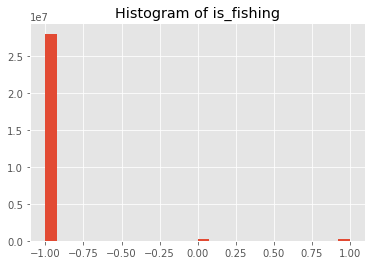

In [56]:
boats_df['is_fishing'].hist(bins='auto');
plt.title('Histogram of is_fishing')

Text(0.5, 1.0, 'Histogram of is_fishing no -1 labels')

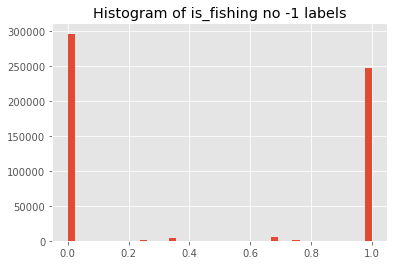

In [57]:
# look at distribution ignoring -1 labels as these contain no info
boats_df.loc[boats_df['is_fishing'] != -1]['is_fishing'].hist(bins='auto');
plt.title('Histogram of is_fishing no -1 labels')

Distribution of our target labels range from 0 to 1, when removing labels lacking any information (`-1`).  The majority of entries fall as either 0 or 1, and we know from the above descriptions, that values between 0 and 1 indicate the average score if scored by multiple people.  For this reason, any value between 0 and 1 has some sort of uncertainty from a labeling perspective, and these values will be removed in the data preparation stage.  With more than 250,000 `1` labels remaining and more than 295,000 `0` labels remaining, we should have more than enough remaining data after removing values between 0 and 1.  

#### AIS Predictors

In [59]:
# separate out predictors
ais_predictors = boats_df.drop('is_fishing', axis=1)

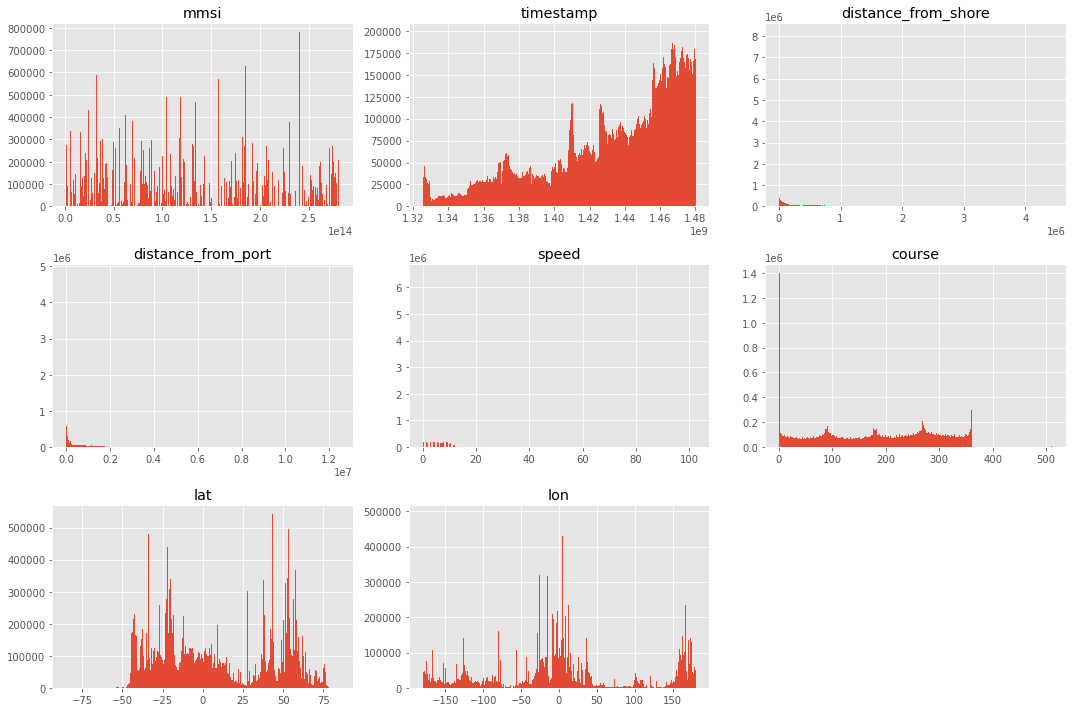

In [63]:
# histogram of continuous predictors
ais_predictors.hist(figsize=(15, 10), bins='auto')
plt.tight_layout()

In [70]:
# discuss findings

In [64]:
# boxplots and other plots to show difference between is_fishing labels

In [73]:
# separate out number columns
num_cols = ['timestamp', 'distance_from_shore', 'distance_from_port',
            'speed', 'course', 'lat', 'lon']

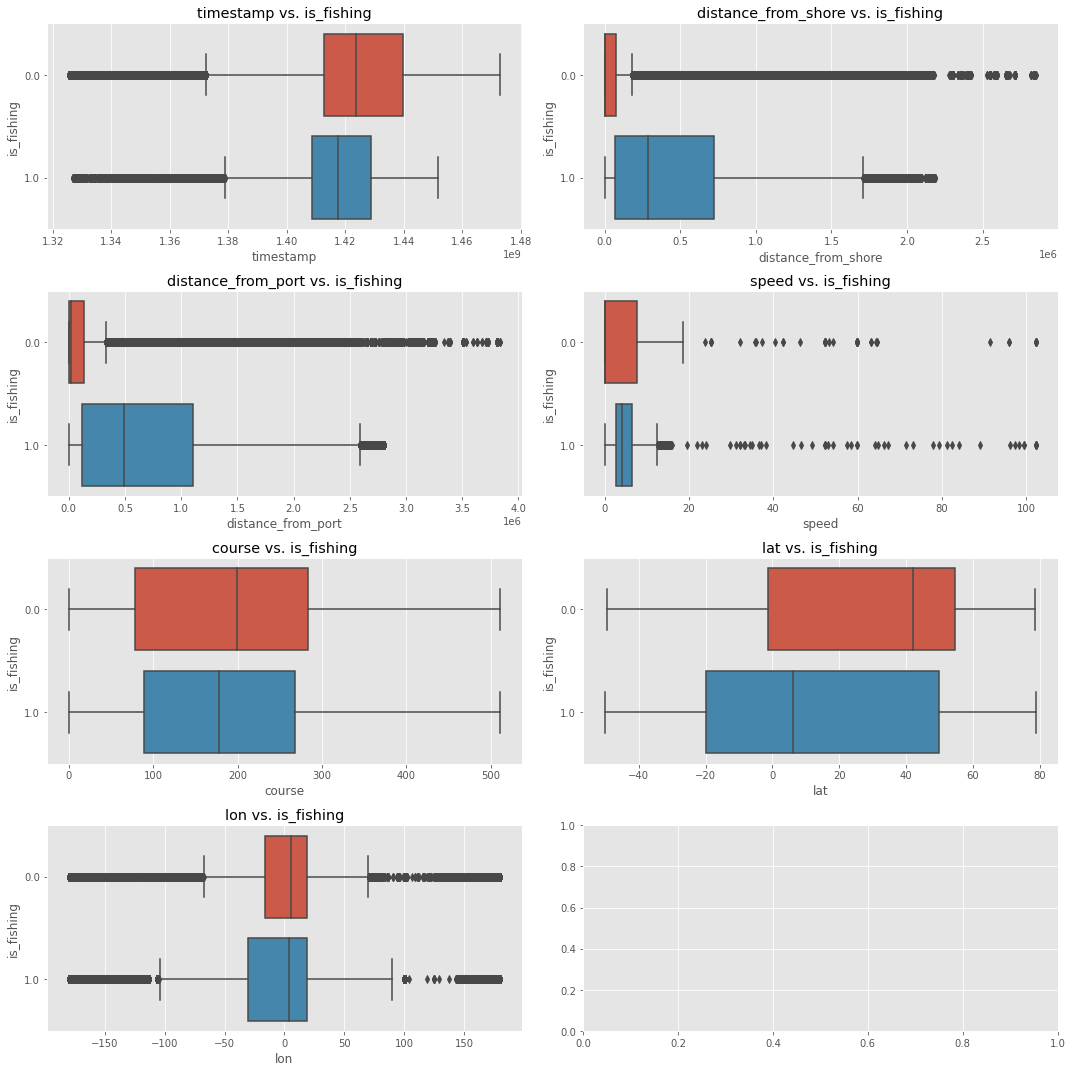

In [78]:
# clean boats to only include 0 and 1 labels
boats_df = boats_df.loc[(boats_df['is_fishing'] == 0) | (boats_df['is_fishing'] == 1)]

# plot boxplots per label
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))
for ax, feat in zip(axes.flatten(), num_cols):
    sns.boxplot(x=feat, y=boats_df['is_fishing'].astype('category'), data=boats_df, ax=ax)
    ax.set_title(f'{feat} vs. is_fishing')
plt.tight_layout()
plt.show()

In [79]:
# discuss findings

In [65]:
# potentially add heatmap to show the breakdown of the data further

## NOAA Ocean Station Data (OSD)
Ocean station data was sourced from the following url: `https://www.ncei.noaa.gov/access/world-ocean-database-select/dbsearch.html`.

Using the WODselect retrieval system enables a user to search World Ocean Database and new data using user-specified criteria. I specifically retreived OSD data using all available coordinates, and limited my timestamps to match the range present in the Global Fishing Watch AIS datasets. 

The World Ocean Database is encoded per the following documentation: `https://www.ncei.noaa.gov/data/oceans/woa/WOD/DOC/wodreadme.pdf`

As a result, downloaded files are returned in a native `.OSD` format.  To handle reading and importing of `.OSD` data, I made use of the `wodpy` package.  More information regarding `wodpy` can be found: `https://github.com/IQuOD/wodpy`.  

In [32]:
# import necessary libraries
from wodpy import wod
fid = open('datasets/ocldb1642977297.29281.OSD')
profile = wod.WodProfile(fid) # test reading of .OSD file
profile

In [33]:
# convert profile to dataframe
ods_profile = profile.df()

/Users/addingtongraham/opt/anaconda3/envs/keras-env/lib/python3.6/site-packages/wodpy/wod.py:792: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.meta = meta


In [34]:
# profile information
ods_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   z           93 non-null     float64
 1   z_level_qc  93 non-null     int64  
 2   z_unc       0 non-null      float64
 3   t           91 non-null     float64
 4   t_level_qc  91 non-null     float64
 5   t_unc       0 non-null      float64
 6   s           91 non-null     float64
 7   s_level_qc  91 non-null     float64
 8   s_unc       0 non-null      float64
 9   oxygen      91 non-null     float64
 10  phosphate   91 non-null     float64
 11  silicate    91 non-null     float64
 12  pH          91 non-null     float64
 13  p           0 non-null      float64
dtypes: float64(13), int64(1)
memory usage: 10.3 KB


After successful loading of one OSD profile, we have access to the following information:
* `z`: level depths in meters
* `z_level_qc`: level depth qc flags (0 == all good)
* `z_unc`: depth uncertainty
* `t`: level temperature in Celcius
* `t_level_qc`: level temperature qc flags (0 == all good)
* `t_unc`: temperature uncertainty
* `s`: level salinities
* `s_level_qc`: level salinity qc flags (0 == all good)
* `s_unc`: salinity uncertainty
* `oxygen`: oxygen content (mL / L)
* `phosphate`: phosphate content (uM / L)
* `silicate`: silicate content (uM / L)
* `pH`: pH levels
* `p`: pressure (decibar)

In [35]:
# each profile also has additional information stored in the .meta attribute
ods_profile.meta

{'latitude': 2.2528,
 'latitude_unc': None,
 'longitude': 146.783,
 'longitude_unc': None,
 'uid': 16621322,
 'n_levels': 93,
 'year': 2012,
 'month': 1,
 'day': 1,
 'time': 0.667,
 'cruise': 39079,
 'probe_type': 7.0,
 'originator_flag_type': 1.0,
 'PIs': None,
 'originator_station': None,
 'originator_cruise': '49NZ20111220',
 't_metadata': [{'value': 103.0, 'code': 3, 'iMeta': 0},
  {'value': 4.0, 'code': 5, 'iMeta': 0}],
 's_metadata': [{'value': 202.0, 'code': 3, 'iMeta': 0}]}

Looking at the metadata for our first ODS profile, we can see there is a bunch of additional relevant information here, particularly the latitude and longitude information, which we can ultimately use to merge with our AIS data. 

In [36]:
# reset ODS reader
ods_file = open('datasets/ocldb1642977297.29281.OSD')
ods_profile = wod.WodProfile(fid)

In [37]:
# use while loop to pull in all profiles
ods_df = pd.DataFrame()
n = 1 # used to track loop progress

while ods_profile.is_last_profile_in_file(fid) == False:
    
    # get df and meta information
    profile_df = ods_profile.df()
    profile_meta = profile_df.meta
    
    # add columns
    profile_df['lat'] = profile_meta['latitude']
    profile_df['lon'] = profile_meta['longitude']
    profile_df['year'] = profile_meta['year']
    profile_df['month'] = profile_meta['month']
    profile_df['day'] = profile_meta['day']
    profile_df['time'] = profile_meta['time']
    
    # concat df
    ods_df = pd.concat([profile_df, ods_df], axis=0)
    
    # update to next ods_profile
    ods_profile = wod.WodProfile(fid)
    
    print(n)
    n += 1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072


3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732


5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394


6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047


8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696


10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
10247
10248
10249
10250
10251
10252
10253
10254
10255
10256
10257
10258
10259
10260
10261
10262
10263
10264
10265
10266
10267
10268
10269
10270
10271
10272
10273
10274
10275
10276
10277
10278
10279
10280
10281
10282
10283
10284
10285
10286
10287
10288
1028

11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
11619
11620
11621
11622
11623
11624
11625
11626
11627
11628
11629
11630
11631
11632
11633
11634
11635
11636
11637
11638
11639
11640
11641
11642
11643
11644
11645
11646
11647
11648
11649
11650
11651
11652
11653
11654
11655
11656
11657
11658
11659
11660
11661
11662
11663
1166

12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
12962
12963
12964
12965
12966
12967
12968
12969
12970
12971
12972
12973
12974
12975
12976
12977
12978
12979
12980
12981
12982
12983
12984
12985
12986
12987
12988
12989
12990
12991
12992
12993
12994
12995
12996
12997
12998
12999
13000
13001
13002
13003
13004
13005
13006
13007
13008
13009
13010
13011
13012
13013
13014
13015
13016
13017
13018
13019
13020
13021
13022
13023
13024
13025
13026
13027
13028
13029
13030
13031
13032
13033
13034
13035
13036
13037
13038
13039
1304

14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
14341
14342
14343
14344
14345
14346
14347
14348
14349
14350
14351
14352
14353
14354
14355
14356
14357
14358
14359
14360
14361
14362
14363
14364
14365
14366
14367
14368
14369
14370
14371
14372
14373
14374
14375
14376
14377
14378
14379
14380
14381
14382
14383
14384
14385
14386
14387
14388
14389
14390
14391
14392
14393
14394
14395
14396
14397
14398
14399
14400
14401
14402
14403
14404
14405
14406
14407
14408
14409
14410
14411
14412
14413
14414
14415
1441

15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
15689
15690
15691
15692
15693
15694
15695
15696
15697
15698
15699
15700
15701
15702
15703
15704
15705
15706
15707
15708
15709
15710
15711
15712
15713
15714
15715
15716
15717
15718
15719
15720
15721
15722
15723
15724
15725
15726
15727
15728
15729
15730
15731
15732
15733
15734
15735
15736
15737
15738
15739
15740
15741
15742
15743
15744
15745
15746
15747
15748
15749
15750
15751
15752
15753
15754
15755
15756
15757
15758
15759
15760
15761
15762
15763
15764
15765
15766
15767
15768
15769
15770
15771
15772
15773
15774
15775
15776
15777
15778
15779
15780
15781
15782
15783
15784
15785
15786
1578

16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
17043
17044
17045
17046
17047
17048
17049
17050
17051
17052
17053
17054
17055
17056
17057
17058
17059
17060
17061
17062
17063
17064
17065
17066
17067
17068
17069
17070
17071
17072
17073
17074
17075
17076
17077
17078
17079
17080
17081
17082
17083
17084
17085
17086
17087
17088
17089
17090
17091
17092
17093
17094
17095
17096
17097
17098
17099
17100
17101
17102
17103
17104
17105
17106
17107
17108
17109
17110
17111
17112
17113
17114
17115
17116
17117
17118
17119
17120
17121
17122
17123
17124
17125
17126
17127
17128
17129
17130
17131
17132
17133
17134
17135
17136
17137
17138
17139
17140
17141
17142
17143
17144
17145
17146
17147
17148
17149
17150
17151
17152
17153
17154
17155
17156
17157
17158
17159
1716

18364
18365
18366
18367
18368
18369
18370
18371
18372
18373
18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
18399
18400
18401
18402
18403
18404
18405
18406
18407
18408
18409
18410
18411
18412
18413
18414
18415
18416
18417
18418
18419
18420
18421
18422
18423
18424
18425
18426
18427
18428
18429
18430
18431
18432
18433
18434
18435
18436
18437
18438
18439
18440
18441
18442
18443
18444
18445
18446
18447
18448
18449
18450
18451
18452
18453
18454
18455
18456
18457
18458
18459
18460
18461
18462
18463
18464
18465
18466
18467
18468
18469
18470
18471
18472
18473
18474
18475
18476
18477
18478
18479
18480
18481
18482
18483
18484
18485
18486
18487
18488
18489
18490
18491
18492
18493
18494
18495
18496
18497
18498
18499
18500
18501
18502
18503
18504
18505
18506
18507
18508
18509
18510
18511
18512
18513
18514
18515
18516
18517
18518
18519
18520
18521
18522
18523
18524
18525
18526
18527
18528
18529
1853

19733
19734
19735
19736
19737
19738
19739
19740
19741
19742
19743
19744
19745
19746
19747
19748
19749
19750
19751
19752
19753
19754
19755
19756
19757
19758
19759
19760
19761
19762
19763
19764
19765
19766
19767
19768
19769
19770
19771
19772
19773
19774
19775
19776
19777
19778
19779
19780
19781
19782
19783
19784
19785
19786
19787
19788
19789
19790
19791
19792
19793
19794
19795
19796
19797
19798
19799
19800
19801
19802
19803
19804
19805
19806
19807
19808
19809
19810
19811
19812
19813
19814
19815
19816
19817
19818
19819
19820
19821
19822
19823
19824
19825
19826
19827
19828
19829
19830
19831
19832
19833
19834
19835
19836
19837
19838
19839
19840
19841
19842
19843
19844
19845
19846
19847
19848
19849
19850
19851
19852
19853
19854
19855
19856
19857
19858
19859
19860
19861
19862
19863
19864
19865
19866
19867
19868
19869
19870
19871
19872
19873
19874
19875
19876
19877
19878
19879
19880
19881
19882
19883
19884
19885
19886
19887
19888
19889
19890
19891
19892
19893
19894
19895
19896
19897
19898
1989

21110
21111
21112
21113
21114
21115
21116
21117
21118
21119
21120
21121
21122
21123
21124
21125
21126
21127
21128
21129
21130
21131
21132
21133
21134
21135
21136
21137
21138
21139
21140
21141
21142
21143
21144
21145
21146
21147
21148
21149
21150
21151
21152
21153
21154
21155
21156
21157
21158
21159
21160
21161
21162
21163
21164
21165
21166
21167
21168
21169
21170
21171
21172
21173
21174
21175
21176
21177
21178
21179
21180
21181
21182
21183
21184
21185
21186
21187
21188
21189
21190
21191
21192
21193
21194
21195
21196
21197
21198
21199
21200
21201
21202
21203
21204
21205
21206
21207
21208
21209
21210
21211
21212
21213
21214
21215
21216
21217
21218
21219
21220
21221
21222
21223
21224
21225
21226
21227
21228
21229
21230
21231
21232
21233
21234
21235
21236
21237
21238
21239
21240
21241
21242
21243
21244
21245
21246
21247
21248
21249
21250
21251
21252
21253
21254
21255
21256
21257
21258
21259
21260
21261
21262
21263
21264
21265
21266
21267
21268
21269
21270
21271
21272
21273
21274
21275
2127

22482
22483
22484
22485
22486
22487
22488
22489
22490
22491
22492
22493
22494
22495
22496
22497
22498
22499
22500
22501
22502
22503
22504
22505
22506
22507
22508
22509
22510
22511
22512
22513
22514
22515
22516
22517
22518
22519
22520
22521
22522
22523
22524
22525
22526
22527
22528
22529
22530
22531
22532
22533
22534
22535
22536
22537
22538
22539
22540
22541
22542
22543
22544
22545
22546
22547
22548
22549
22550
22551
22552
22553
22554
22555
22556
22557
22558
22559
22560
22561
22562
22563
22564
22565
22566
22567
22568
22569
22570
22571
22572
22573
22574
22575
22576
22577
22578
22579
22580
22581
22582
22583
22584
22585
22586
22587
22588
22589
22590
22591
22592
22593
22594
22595
22596
22597
22598
22599
22600
22601
22602
22603
22604
22605
22606
22607
22608
22609
22610
22611
22612
22613
22614
22615
22616
22617
22618
22619
22620
22621
22622
22623
22624
22625
22626
22627
22628
22629
22630
22631
22632
22633
22634
22635
22636
22637
22638
22639
22640
22641
22642
22643
22644
22645
22646
22647
2264

23850
23851
23852
23853
23854
23855
23856
23857
23858
23859
23860
23861
23862
23863
23864
23865
23866
23867
23868
23869
23870
23871
23872
23873
23874
23875
23876
23877
23878
23879
23880
23881
23882
23883
23884
23885
23886
23887
23888
23889
23890
23891
23892
23893
23894
23895
23896
23897
23898
23899
23900
23901
23902
23903
23904
23905
23906
23907
23908
23909
23910
23911
23912
23913
23914
23915
23916
23917
23918
23919
23920
23921
23922
23923
23924
23925
23926
23927
23928
23929
23930
23931
23932
23933
23934
23935
23936
23937
23938
23939
23940
23941
23942
23943
23944
23945
23946
23947
23948
23949
23950
23951
23952
23953
23954
23955
23956
23957
23958
23959
23960
23961
23962
23963
23964
23965
23966
23967
23968
23969
23970
23971
23972
23973
23974
23975
23976
23977
23978
23979
23980
23981
23982
23983
23984
23985
23986
23987
23988
23989
23990
23991
23992
23993
23994
23995
23996
23997
23998
23999
24000
24001
24002
24003
24004
24005
24006
24007
24008
24009
24010
24011
24012
24013
24014
24015
2401

25219
25220
25221
25222
25223
25224
25225
25226
25227
25228
25229
25230
25231
25232
25233
25234
25235
25236
25237
25238
25239
25240
25241
25242
25243
25244
25245
25246
25247
25248
25249
25250
25251
25252
25253
25254
25255
25256
25257
25258
25259
25260
25261
25262
25263
25264
25265
25266
25267
25268
25269
25270
25271
25272
25273
25274
25275
25276
25277
25278
25279
25280
25281
25282
25283
25284
25285
25286
25287
25288
25289
25290
25291
25292
25293
25294
25295
25296
25297
25298
25299
25300
25301
25302
25303
25304
25305
25306
25307
25308
25309
25310
25311
25312
25313
25314
25315
25316
25317
25318
25319
25320
25321
25322
25323
25324
25325
25326
25327
25328
25329
25330
25331
25332
25333
25334
25335
25336
25337
25338
25339
25340
25341
25342
25343
25344
25345
25346
25347
25348
25349
25350
25351
25352
25353
25354
25355
25356
25357
25358
25359
25360
25361
25362
25363
25364
25365
25366
25367
25368
25369
25370
25371
25372
25373
25374
25375
25376
25377
25378
25379
25380
25381
25382
25383
25384
2538

26591
26592
26593
26594
26595
26596
26597
26598
26599
26600
26601
26602
26603
26604
26605
26606
26607
26608
26609
26610
26611
26612
26613
26614
26615
26616
26617
26618
26619
26620
26621
26622
26623
26624
26625
26626
26627
26628
26629
26630
26631
26632
26633
26634
26635
26636
26637
26638
26639
26640
26641
26642
26643
26644
26645
26646
26647
26648
26649
26650
26651
26652
26653
26654
26655
26656
26657
26658
26659
26660
26661
26662
26663
26664
26665
26666
26667
26668
26669
26670
26671
26672
26673
26674
26675
26676
26677
26678
26679
26680
26681
26682
26683
26684
26685
26686
26687
26688
26689
26690
26691
26692
26693
26694
26695
26696
26697
26698
26699
26700
26701
26702
26703
26704
26705
26706
26707
26708
26709
26710
26711
26712
26713
26714
26715
26716
26717
26718
26719
26720
26721
26722
26723
26724
26725
26726
26727
26728
26729
26730
26731
26732
26733
26734
26735
26736
26737
26738
26739
26740
26741
26742
26743
26744
26745
26746
26747
26748
26749
26750
26751
26752
26753
26754
26755
26756
2675

27965
27966
27967
27968
27969
27970
27971
27972
27973
27974
27975
27976
27977
27978
27979
27980
27981
27982
27983
27984
27985
27986
27987
27988
27989
27990
27991
27992
27993
27994
27995
27996
27997
27998
27999
28000
28001
28002
28003
28004
28005
28006
28007
28008
28009
28010
28011
28012
28013
28014
28015
28016
28017
28018
28019
28020
28021
28022
28023
28024
28025
28026
28027
28028
28029
28030
28031
28032
28033
28034
28035
28036
28037
28038
28039
28040
28041
28042
28043
28044
28045
28046
28047
28048
28049
28050
28051
28052
28053
28054
28055
28056
28057
28058
28059
28060
28061
28062
28063
28064
28065
28066
28067
28068
28069
28070
28071
28072
28073
28074
28075
28076
28077
28078
28079
28080
28081
28082
28083
28084
28085
28086
28087
28088
28089
28090
28091
28092
28093
28094
28095
28096
28097
28098
28099
28100
28101
28102
28103
28104
28105
28106
28107
28108
28109
28110
28111
28112
28113
28114
28115
28116
28117
28118
28119
28120
28121
28122
28123
28124
28125
28126
28127
28128
28129
28130
2813

29334
29335
29336
29337
29338
29339
29340
29341
29342
29343
29344
29345
29346
29347
29348
29349
29350
29351
29352
29353
29354
29355
29356
29357
29358
29359
29360
29361
29362
29363
29364
29365
29366
29367
29368
29369
29370
29371
29372
29373
29374
29375
29376
29377
29378
29379
29380
29381
29382
29383
29384
29385
29386
29387
29388
29389
29390
29391
29392
29393
29394
29395
29396
29397
29398
29399
29400
29401
29402
29403
29404
29405
29406
29407
29408
29409
29410
29411
29412
29413
29414
29415
29416
29417
29418
29419
29420
29421
29422
29423
29424
29425
29426
29427
29428
29429
29430
29431
29432
29433
29434
29435
29436
29437
29438
29439
29440
29441
29442
29443
29444
29445
29446
29447
29448
29449
29450
29451
29452
29453
29454
29455
29456
29457
29458
29459
29460
29461
29462
29463
29464
29465
29466
29467
29468
29469
29470
29471
29472
29473
29474
29475
29476
29477
29478
29479
29480
29481
29482
29483
29484
29485
29486
29487
29488
29489
29490
29491
29492
29493
29494
29495
29496
29497
29498
29499
2950

30704
30705
30706
30707
30708
30709
30710
30711
30712
30713
30714
30715
30716
30717
30718
30719
30720
30721
30722
30723
30724
30725
30726
30727
30728
30729
30730
30731
30732
30733
30734
30735
30736
30737
30738
30739
30740
30741
30742
30743
30744
30745
30746
30747
30748
30749
30750
30751
30752
30753
30754
30755
30756
30757
30758
30759
30760
30761
30762
30763
30764
30765
30766
30767
30768
30769
30770
30771
30772
30773
30774
30775
30776
30777
30778
30779
30780
30781
30782
30783
30784
30785
30786
30787
30788
30789
30790
30791
30792
30793
30794
30795
30796
30797
30798
30799
30800
30801
30802
30803
30804
30805
30806
30807
30808
30809
30810
30811
30812
30813
30814
30815
30816
30817
30818
30819
30820
30821
30822
30823
30824
30825
30826
30827
30828
30829
30830
30831
30832
30833
30834
30835
30836
30837
30838
30839
30840
30841
30842
30843
30844
30845
30846
30847
30848
30849
30850
30851
30852
30853
30854
30855
30856
30857
30858
30859
30860
30861
30862
30863
30864
30865
30866
30867
30868
30869
3087

32071
32072
32073
32074
32075
32076
32077
32078
32079
32080
32081
32082
32083
32084
32085
32086
32087
32088
32089
32090
32091
32092
32093
32094
32095
32096
32097
32098
32099
32100
32101
32102
32103
32104
32105
32106
32107
32108
32109
32110
32111
32112
32113
32114
32115
32116
32117
32118
32119
32120
32121
32122
32123
32124
32125
32126
32127
32128
32129
32130
32131
32132
32133
32134
32135
32136
32137
32138
32139
32140
32141
32142
32143
32144
32145
32146
32147
32148
32149
32150
32151
32152
32153
32154
32155
32156
32157
32158
32159
32160
32161
32162
32163
32164
32165
32166
32167
32168
32169
32170
32171
32172
32173
32174
32175
32176
32177
32178
32179
32180
32181
32182
32183
32184
32185
32186
32187
32188
32189
32190
32191
32192
32193
32194
32195
32196
32197
32198
32199
32200
32201
32202
32203
32204
32205
32206
32207
32208
32209
32210
32211
32212
32213
32214
32215
32216
32217
32218
32219
32220
32221
32222
32223
32224
32225
32226
32227
32228
32229
32230
32231
32232
32233
32234
32235
32236
3223

33441
33442
33443
33444
33445
33446
33447
33448
33449
33450
33451
33452
33453
33454
33455
33456
33457
33458
33459
33460
33461
33462
33463
33464
33465
33466
33467
33468
33469
33470
33471
33472
33473
33474
33475
33476
33477
33478
33479
33480
33481
33482
33483
33484
33485
33486
33487
33488
33489
33490
33491
33492
33493
33494
33495
33496
33497
33498
33499
33500
33501
33502
33503
33504
33505
33506
33507
33508
33509
33510
33511
33512
33513
33514
33515
33516
33517
33518
33519
33520
33521
33522
33523
33524
33525
33526
33527
33528
33529
33530
33531
33532
33533
33534
33535
33536
33537
33538
33539
33540
33541
33542
33543
33544
33545
33546
33547
33548
33549
33550
33551
33552
33553
33554
33555
33556
33557
33558
33559
33560
33561
33562
33563
33564
33565
33566
33567
33568
33569
33570
33571
33572
33573
33574
33575
33576
33577
33578
33579
33580
33581
33582
33583
33584
33585
33586
33587
33588
33589
33590
33591
33592
33593
33594
33595
33596
33597
33598
33599
33600
33601
33602
33603
33604
33605
33606
3360

34812
34813
34814
34815
34816
34817
34818
34819
34820
34821
34822
34823
34824
34825
34826
34827
34828
34829
34830
34831
34832
34833
34834
34835
34836
34837
34838
34839
34840
34841
34842
34843
34844
34845
34846
34847
34848
34849
34850
34851
34852
34853
34854
34855
34856
34857
34858
34859
34860
34861
34862
34863
34864
34865
34866
34867
34868
34869
34870
34871
34872
34873
34874
34875
34876
34877
34878
34879
34880
34881
34882
34883
34884
34885
34886
34887
34888
34889
34890
34891
34892
34893
34894
34895
34896
34897
34898
34899
34900
34901
34902
34903
34904
34905
34906
34907
34908
34909
34910
34911
34912
34913
34914
34915
34916
34917
34918
34919
34920
34921
34922
34923
34924
34925
34926
34927
34928
34929
34930
34931
34932
34933
34934
34935
34936
34937
34938
34939
34940
34941
34942
34943
34944
34945
34946
34947
34948
34949
34950
34951
34952
34953
34954
34955
34956
34957
34958
34959
34960
34961
34962
34963
34964
34965
34966
34967
34968
34969
34970
34971
34972
34973
34974
34975
34976
34977
3497

36181
36182
36183
36184
36185
36186
36187
36188
36189
36190
36191
36192
36193
36194
36195
36196
36197
36198
36199
36200
36201
36202
36203
36204
36205
36206
36207
36208
36209
36210
36211
36212
36213
36214
36215
36216
36217
36218
36219
36220
36221
36222
36223
36224
36225
36226
36227
36228
36229
36230
36231
36232
36233
36234
36235
36236
36237
36238
36239
36240
36241
36242
36243
36244
36245
36246
36247
36248
36249
36250
36251
36252
36253
36254
36255
36256
36257
36258
36259
36260
36261
36262
36263
36264
36265
36266
36267
36268
36269
36270
36271
36272
36273
36274
36275
36276
36277
36278
36279
36280
36281
36282
36283
36284
36285
36286
36287
36288
36289
36290
36291
36292
36293
36294
36295
36296
36297
36298
36299
36300
36301
36302
36303
36304
36305
36306
36307
36308
36309
36310
36311
36312
36313
36314
36315
36316
36317
36318
36319
36320
36321
36322
36323
36324
36325
36326
36327
36328
36329
36330
36331
36332
36333
36334
36335
36336
36337
36338
36339
36340
36341
36342
36343
36344
36345
36346
3634

37551
37552
37553
37554
37555
37556
37557
37558
37559
37560
37561
37562
37563
37564
37565
37566
37567
37568
37569
37570
37571
37572
37573
37574
37575
37576
37577
37578
37579
37580
37581
37582
37583
37584
37585
37586
37587
37588
37589
37590
37591
37592
37593
37594
37595
37596
37597
37598
37599
37600
37601
37602
37603
37604
37605
37606
37607
37608
37609
37610
37611
37612
37613
37614
37615
37616
37617
37618
37619
37620
37621
37622
37623
37624
37625
37626
37627
37628
37629
37630
37631
37632
37633
37634
37635
37636
37637
37638
37639
37640
37641
37642
37643
37644
37645
37646
37647
37648
37649
37650
37651
37652
37653
37654
37655
37656
37657
37658
37659
37660
37661
37662
37663
37664
37665
37666
37667
37668
37669
37670
37671
37672
37673
37674
37675
37676
37677
37678
37679
37680
37681
37682
37683
37684
37685
37686
37687
37688
37689
37690
37691
37692
37693
37694
37695
37696
37697
37698
37699
37700
37701
37702
37703
37704
37705
37706
37707
37708
37709
37710
37711
37712
37713
37714
37715
37716
3771

38923
38924
38925
38926
38927
38928
38929
38930
38931
38932
38933
38934
38935
38936
38937
38938
38939
38940
38941
38942
38943
38944
38945
38946
38947
38948
38949
38950
38951
38952
38953
38954
38955
38956
38957
38958
38959
38960
38961
38962
38963
38964
38965
38966
38967
38968
38969
38970
38971
38972
38973
38974
38975
38976
38977
38978
38979
38980
38981
38982
38983
38984
38985
38986
38987
38988
38989
38990
38991
38992
38993
38994
38995
38996
38997
38998
38999
39000
39001
39002
39003
39004
39005
39006
39007
39008
39009
39010
39011
39012
39013
39014
39015
39016
39017
39018
39019
39020
39021
39022
39023
39024
39025
39026
39027
39028
39029
39030
39031
39032
39033
39034
39035
39036
39037
39038
39039
39040
39041
39042
39043
39044
39045
39046
39047
39048
39049
39050
39051
39052
39053
39054
39055
39056
39057
39058
39059
39060
39061
39062
39063
39064
39065
39066
39067
39068
39069
39070
39071
39072
39073
39074
39075
39076
39077
39078
39079
39080
39081
39082
39083
39084
39085
39086
39087
39088
3908

40290
40291
40292
40293
40294
40295
40296
40297
40298
40299
40300
40301
40302
40303
40304
40305
40306
40307
40308
40309
40310
40311
40312
40313
40314
40315
40316
40317
40318
40319
40320
40321
40322
40323
40324
40325
40326
40327
40328
40329
40330
40331
40332
40333
40334
40335
40336
40337
40338
40339
40340
40341
40342
40343
40344
40345
40346
40347
40348
40349
40350
40351
40352
40353
40354
40355
40356
40357
40358
40359
40360
40361
40362
40363
40364
40365
40366
40367
40368
40369
40370
40371
40372
40373
40374
40375
40376
40377
40378
40379
40380
40381
40382
40383
40384
40385
40386
40387
40388
40389
40390
40391
40392
40393
40394
40395
40396
40397
40398
40399
40400
40401
40402
40403
40404
40405
40406
40407
40408
40409
40410
40411
40412
40413
40414
40415
40416
40417
40418
40419
40420
40421
40422
40423
40424
40425
40426
40427
40428
40429
40430
40431
40432
40433
40434
40435
40436
40437
40438
40439
40440
40441
40442
40443
40444
40445
40446
40447
40448
40449
40450
40451
40452
40453
40454
40455
4045

41659
41660
41661
41662
41663
41664
41665
41666
41667
41668
41669
41670
41671
41672
41673
41674
41675
41676
41677
41678
41679
41680
41681
41682
41683
41684
41685
41686
41687
41688
41689
41690
41691
41692
41693
41694
41695
41696
41697
41698
41699
41700
41701
41702
41703
41704
41705
41706
41707
41708
41709
41710
41711
41712
41713
41714
41715
41716
41717
41718
41719
41720
41721
41722
41723
41724
41725
41726
41727
41728
41729
41730
41731
41732
41733
41734
41735
41736
41737
41738
41739
41740
41741
41742
41743
41744
41745
41746
41747
41748
41749
41750
41751
41752
41753
41754
41755
41756
41757
41758
41759
41760
41761
41762
41763
41764
41765
41766
41767
41768
41769
41770
41771
41772
41773
41774
41775
41776
41777
41778
41779
41780
41781
41782
41783
41784
41785
41786
41787
41788
41789
41790
41791
41792
41793
41794
41795
41796
41797
41798
41799
41800
41801
41802
41803
41804
41805
41806
41807
41808
41809
41810
41811
41812
41813
41814
41815
41816
41817
41818
41819
41820
41821
41822
41823
41824
4182

43026
43027
43028
43029
43030
43031
43032
43033
43034
43035
43036
43037
43038
43039
43040
43041
43042
43043
43044
43045
43046
43047
43048
43049
43050
43051
43052
43053
43054
43055
43056
43057
43058
43059
43060
43061
43062
43063
43064
43065
43066
43067
43068
43069
43070
43071
43072
43073
43074
43075
43076
43077
43078
43079
43080
43081
43082
43083
43084
43085
43086
43087
43088
43089
43090
43091
43092
43093
43094
43095
43096
43097
43098
43099
43100
43101
43102
43103
43104
43105
43106
43107
43108
43109
43110
43111
43112
43113
43114
43115
43116
43117
43118
43119
43120
43121
43122
43123
43124
43125
43126
43127
43128
43129
43130
43131
43132
43133
43134
43135
43136
43137
43138
43139
43140
43141
43142
43143
43144
43145
43146
43147
43148
43149
43150
43151
43152
43153
43154
43155
43156
43157
43158
43159
43160
43161
43162
43163
43164
43165
43166
43167
43168
43169
43170
43171
43172
43173
43174
43175
43176
43177
43178
43179
43180
43181
43182
43183
43184
43185
43186
43187
43188
43189
43190
43191
4319

44393
44394
44395
44396
44397
44398
44399
44400
44401
44402
44403
44404
44405
44406
44407
44408
44409
44410
44411
44412
44413
44414
44415
44416
44417
44418
44419
44420
44421
44422
44423
44424
44425
44426
44427
44428
44429
44430
44431
44432
44433
44434
44435
44436
44437
44438
44439
44440
44441
44442
44443
44444
44445
44446
44447
44448
44449
44450
44451
44452
44453
44454
44455
44456
44457
44458
44459
44460
44461
44462
44463
44464
44465
44466
44467
44468
44469
44470
44471
44472
44473
44474
44475
44476
44477
44478
44479
44480
44481
44482
44483
44484
44485
44486
44487
44488
44489
44490
44491
44492
44493
44494
44495
44496
44497
44498
44499
44500
44501
44502
44503
44504
44505
44506
44507
44508
44509
44510
44511
44512
44513
44514
44515
44516
44517
44518
44519
44520
44521
44522
44523
44524
44525
44526
44527
44528
44529
44530
44531
44532
44533
44534
44535
44536
44537
44538
44539
44540
44541
44542
44543
44544
44545
44546
44547
44548
44549
44550
44551
44552
44553
44554
44555
44556
44557
44558
4455

In [38]:
# display first 5 rows
ods_df.head()

,z,z_level_qc,z_unc,t,t_level_qc,t_unc,s,s_level_qc,s_unc,oxygen,phosphate,silicate,pH,p,lat,lon,year,month,day,time
0,0.0,0,NaN,27.8156,0.0,NaN,32.7162,0.0,NaN,201.1,0.142,0.5,8.0892,NaN,9.4996,-110.0001,2016,12,1,16.13
1,5.0,0,NaN,27.7961,0.0,NaN,32.7229,0.0,NaN,201.0,0.145,0.5,8.0887,NaN,9.4996,-110.0001,2016,12,1,16.13
2,10.0,0,NaN,27.7499,0.0,NaN,32.7388,0.0,NaN,200.7,0.153,0.6,8.0876,NaN,9.4996,-110.0001,2016,12,1,16.13
3,15.0,0,NaN,27.7037,0.0,NaN,32.7548,0.0,NaN,200.4,0.160,0.6,8.0865,NaN,9.4996,-110.0001,2016,12,1,16.13
4,20.0,0,NaN,27.6576,0.0,NaN,32.7707,0.0,NaN,200.1,0.168,0.6,8.0854,NaN,9.4996,-110.0001,2016,12,1,16.13


In [39]:
# display info
ods_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 554826 entries, 0 to 0
Data columns (total 20 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   z           554826 non-null  float64
 1   z_level_qc  554826 non-null  int64  
 2   z_unc       0 non-null       float64
 3   t           466323 non-null  float64
 4   t_level_qc  466323 non-null  float64
 5   t_unc       0 non-null       float64
 6   s           422020 non-null  float64
 7   s_level_qc  422020 non-null  float64
 8   s_unc       0 non-null       float64
 9   oxygen      406869 non-null  float64
 10  phosphate   383805 non-null  float64
 11  silicate    377030 non-null  float64
 12  pH          182788 non-null  float64
 13  p           0 non-null       float64
 14  lat         554826 non-null  float64
 15  lon         554826 non-null  float64
 16  year        554826 non-null  int64  
 17  month       554826 non-null  int64  
 18  day         554826 non-null  int64  
 19  time   

In [40]:
# summary stats of cont. columns
ods_df.describe()

,z,z_level_qc,z_unc,t,t_level_qc,t_unc,s,s_level_qc,s_unc,oxygen,phosphate,silicate,pH,p,lat,lon,year,month,day,time
count,554826.000000,554826.0,0.0,466323.000000,466323.000000,0.0,422020.000000,422020.000000,0.0,406869.000000,383805.000000,377030.000000,182788.000000,0.0,554826.000000,554826.000000,554826.000000,554826.000000,554826.000000,546470.000000
mean,664.650025,0.0,NaN,8.674232,0.084025,NaN,28.492345,0.291901,NaN,212.464138,1.331758,42.866184,7.791573,NaN,26.545191,-4.834392,2013.653338,5.940306,15.295453,11.547927
std,1109.273445,0.0,NaN,7.180532,0.753279,NaN,10.973218,1.504564,NaN,95.479393,1.037013,50.018932,0.284217,NaN,36.941103,98.207203,1.409427,3.178841,8.644863,6.594706
min,0.000000,0.0,NaN,-2.949000,0.000000,NaN,0.010000,0.000000,NaN,0.000000,0.000000,0.000000,6.000000,NaN,-70.574200,-179.893400,2012.000000,1.000000,1.000000,0.000000
25%,30.000000,0.0,NaN,2.898000,0.000000,NaN,29.900900,0.000000,NaN,152.000000,0.370000,3.810000,7.584600,NaN,9.482700,-68.376300,2012.000000,4.000000,8.000000,6.420000
50%,90.000000,0.0,NaN,6.878100,0.000000,NaN,34.397700,0.000000,NaN,217.000000,1.090000,17.000000,7.730900,NaN,33.781700,0.394500,2013.000000,6.000000,15.000000,11.200000
75%,800.000000,0.0,NaN,12.939000,0.000000,NaN,34.858000,0.000000,NaN,271.000000,2.280000,72.200000,8.000000,NaN,56.000000,25.617000,2015.000000,8.000000,22.000000,16.870000
max,6100.000000,0.0,NaN,31.227400,9.000000,NaN,38.497800,9.000000,NaN,523.000000,12.195000,243.900000,9.200000,NaN,89.990900,179.997200,2016.000000,12.000000,31.000000,23.980000


We can see the ocean station data we've read using `wodpy` takes up 88.9 MB of space.  The dataset itself contains additional features that will ultimately be merged with our AIS data to predict `is_fishing`.  

There are a total of 20 columns in the dataset, and a total of 554,826 entries. All columns are of type float, with the exception of the `z_level_qc`, `year`, `month`, and `day` features, which are of type int.

### Distribution of ODS Data

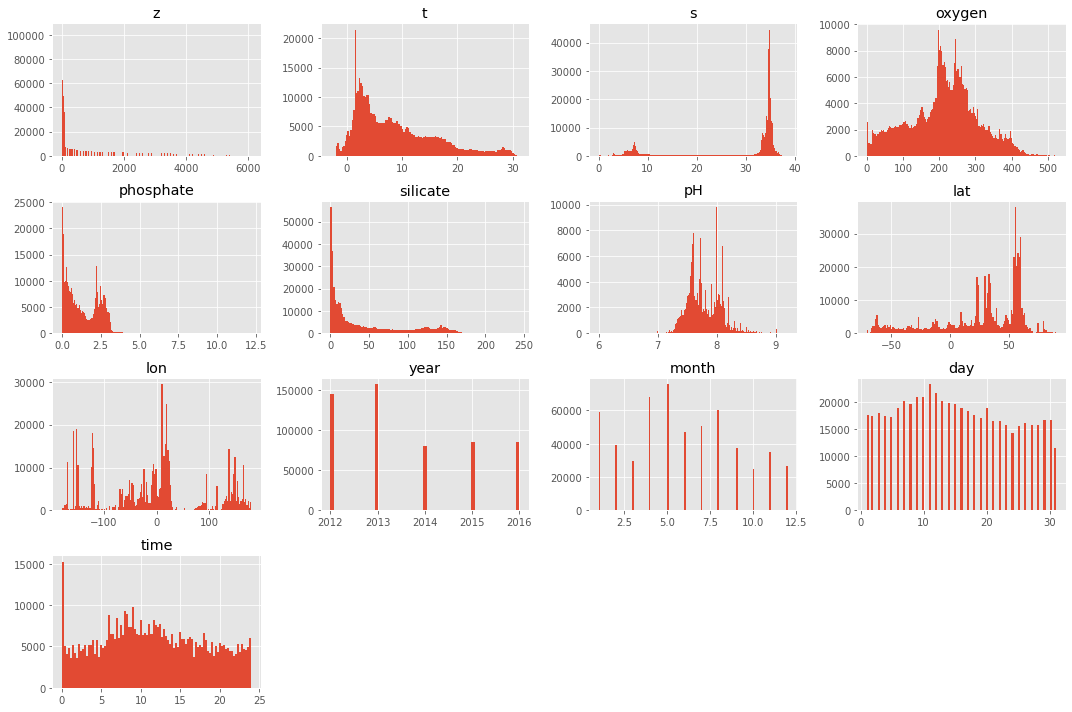

In [69]:
# remove unecessary columns and produce histogram
# drop columns
clean_ods_df = ods_df.drop(['z_level_qc', 'z_unc', 't_level_qc', 't_unc', 
                            's_level_qc', 's_unc', 'p'], axis=1)

# histogram of ODS cont features
clean_ods_df.hist(figsize=(15, 10), bins='auto')
plt.tight_layout()

In [71]:
# discuss findings

In [72]:
# merge datasets and show boxplots and how things differ between labels